# TFM: Análisis de asociaciones en Twitter

# Dataset de Elecciones USA

In [49]:
#https://github.com/falcondai/python-snowflake
# using tweet id from https://twitter.com/falcondai/status/345063379196600321
import datetime

# twitter's snowflake parameters
twepoch = 1288834974657
datacenter_id_bits = 5
worker_id_bits = 5
sequence_id_bits = 12
max_datacenter_id = 1 << datacenter_id_bits
max_worker_id = 1 << worker_id_bits
max_sequence_id = 1 << sequence_id_bits
max_timestamp = 1 << (64 - datacenter_id_bits - worker_id_bits - sequence_id_bits)

def make_snowflake(timestamp_ms, datacenter_id, worker_id, sequence_id, twepoch=twepoch):
    """generate a twitter-snowflake id, based on 
    https://github.com/twitter/snowflake/blob/master/src/main/scala/com/twitter/service/snowflake/IdWorker.scala
    :param: timestamp_ms time since UNIX epoch in milliseconds"""

    sid = ((int(timestamp_ms) - twepoch) % max_timestamp) << datacenter_id_bits << worker_id_bits << sequence_id_bits
    sid += (datacenter_id % max_datacenter_id) << worker_id_bits << sequence_id_bits
    sid += (worker_id % max_worker_id) << sequence_id_bits
    sid += sequence_id % max_sequence_id

    return sid

def melt(snowflake_id, twepoch=twepoch):
    """inversely transform a snowflake id back to its parts."""
    sequence_id = snowflake_id & (max_sequence_id - 1)
    worker_id = (snowflake_id >> sequence_id_bits) & (max_worker_id - 1)
    datacenter_id = (snowflake_id >> sequence_id_bits >> worker_id_bits) & (max_datacenter_id - 1)
    timestamp_ms = snowflake_id >> sequence_id_bits >> worker_id_bits >> datacenter_id_bits
    timestamp_ms += twepoch

    return (timestamp_ms, int(datacenter_id), int(worker_id), int(sequence_id))

def local_datetime(timestamp_ms):
    """convert millisecond timestamp to local datetime object."""
    return datetime.datetime.fromtimestamp(timestamp_ms / 1000.)

if __name__ == '__main__':
    import time
    t0 = int(time.time() * 1000)
    #print(local_datetime(t0))
    assert(melt(make_snowflake(t0, 0, 0, 0))[0] == t0)


In [50]:
def sfk2time(snowflake_id):
    timestamp, data_center, worker, sequence = melt(snowflake_id)
    return local_datetime(timestamp)
    

In [51]:
import numpy as np

def pandas2arff(df,filename,wekaname = "pandasdata",cleanstringdata=True,cleannan=True):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka. 
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values. 
              To suppress this, set this to False
    """
    import re
    
    def cleanstring(s):
        if s!="?":
            return re.sub('[^A-Za-z0-9]+', "_", str(s))
        else:
            return "?"
            
    dfcopy = df #all cleaning operations get done on this copy
    
    if cleannan!=False:
        dfcopy = dfcopy.fillna(-999999999) #this is so that we can swap this out for "?"
        #this makes sure that certain numerical columns with missing values don't get stuck with "object" type
 
    f = open(filename,"w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    #look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i]=='O' or (df.columns[i] in ["Class","CLASS","class"]):
            if cleannan!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].replace(to_replace=-999999999, value="?")
            if cleanstringdata!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].apply(cleanstring)
            _uniqueNominalVals = ["\'"+str(_i)+"\'" for _i in np.unique(dfcopy.iloc[:,i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[","")
            _uniqueNominalVals = _uniqueNominalVals.replace("]","")
            _uniqueValuesString = " {" + _uniqueNominalVals +"}" 
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " {1}\n") 
            #even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")           
    for i in range(dfcopy.shape[0]):#instances
        print(i)
        _instanceString = ""
        for j in range(df.shape[1]):#features
                if dfcopy.dtypes[j]=='O':
                    _instanceString+="\'"+str(dfcopy.iloc[i,j])+"\'"
                else:
                    _instanceString+=str(int(dfcopy.iloc[i,j]))
                if j!=dfcopy.shape[1]-1:#if it's not the last feature, add a comma
                    _instanceString+=","
        _instanceString+="\n"
        if cleannan!=False:
            _instanceString = _instanceString.replace("-999999999","?") #for numeric missing values
            _instanceString = _instanceString.replace("\"?\"","?") #for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True

In [52]:
pandas2arff(df_usa_csar, "usa_arff_fcsar.arff")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [54]:
import pandas as pd
from snowflake import *
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 5000)

## Obtención del Dataset completo con datos ordenados en tiempo

In [55]:
data = './Desktop/data-all-annotations/testdata-taskA-all-annotations.txt'
df_a =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_a.head()

ID   Target  \
0  10001  Atheism   
1  10002  Atheism   
2  10003  Atheism   
3  10004  Atheism   
4  10005  Atheism   

                                                                                                                                   Tweet  \
0  He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12.     #SemST                              
1  RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST          
2  @Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST   
3  #God is utterly powerless without Human intervention... #SemST                                                                          
4  @David_Cameron   Miracles of #Multiculturalism   Miracles of shady 786  #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST   

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          POSITIVE  
1  AGAINST  TARGET          NEITHER   
2  AGAINST  TARGET          POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  AGAINST  OTHER           NEGATIVE

In [56]:
df_a_id =  pd.read_csv('./Desktop/data-all-annotations/testdata-taskA-ids.txt', sep="\t")
id_dic_a=df_a_id.set_index('ID').to_dict()
dic_a=id_dic_a["Tweet ID"]
df_a["ID"].replace(dic_a, inplace=True)
df_a["ID"] = df_a["ID"].map(sfk2time)
df_a.head()

ID   Target  \
0 2015-07-04 08:16:53.155  Atheism   
1 2015-07-04 08:22:15.910  Atheism   
2 2015-07-04 09:40:34.167  Atheism   
3 2015-07-04 11:39:08.286  Atheism   
4 2015-07-04 11:56:25.326  Atheism   

                                                                                                                                   Tweet  \
0  He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12.     #SemST                              
1  RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST          
2  @Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST   
3  #God is utterly powerless without Human intervention... #SemST                                                                          
4  @David_Cameron   Miracles of #Multiculturalism   Miracles of shady 786  #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST   

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          POSITIVE  
1  AGAINST  TARGET          NEITHER   
2  AGAINST  TARGET          POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  AGAINST  OTHER           NEGATIVE

In [57]:
data = './Desktop/data-all-annotations/testdata-taskB-all-annotations.txt'
df_b =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_b.head()

ID        Target  \
0  20001  Donald Trump   
1  20002  Donald Trump   
2  20003  Donald Trump   
3  20004  Donald Trump   
4  20005  Donald Trump   

                                                                                                                                Tweet  \
0  @2014voteblue @ChrisJZullo blindly supporting political parties is willfull ignorance, repub or dem. #SemST                          
1  @ThePimpernelX @Cameron_Gray @CalebHowe  Totally agree ...time to get out of the Twitter Peanut Gallery and take "arms #SemST        
2  @JeffYoung @ThePatriot143 I fully support full repeal. I will work for candidates who I believe will make it happen! #SemST          
3  @ABC Stupid is as stupid does! Showedhis true colors; seems that he ignores that US was invaded, & plundered,not discovered #SemST   
4  @HouseGOP we now have one political party. The Socialist party. No more BS. We don't believe you anymore. #SemST                     

    Stance Opinion towards Sentiment  
0  NONE     OTHER           NEGATIVE  
1  NONE     OTHER           POSITIVE  
2  NONE     OTHER           POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     OTHER           NEGATIVE

In [58]:
df_b_id =  pd.read_csv('./Desktop/data-all-annotations/testdata-taskB-ids.txt', sep="\t")
id_dic_b=df_b_id.set_index('ID').to_dict()
dic_b=id_dic_b["Tweet ID"]
df_b["ID"].replace(dic_b, inplace=True)
df_b["ID"] = df_b["ID"].map(sfk2time)
df_b.head()

ID        Target  \
0 2015-06-25 18:51:16.812  Donald Trump   
1 2015-06-25 18:51:43.145  Donald Trump   
2 2015-06-25 19:09:18.731  Donald Trump   
3 2015-06-25 19:26:11.776  Donald Trump   
4 2015-06-25 19:36:53.840  Donald Trump   

                                                                                                                                Tweet  \
0  @2014voteblue @ChrisJZullo blindly supporting political parties is willfull ignorance, repub or dem. #SemST                          
1  @ThePimpernelX @Cameron_Gray @CalebHowe  Totally agree ...time to get out of the Twitter Peanut Gallery and take "arms #SemST        
2  @JeffYoung @ThePatriot143 I fully support full repeal. I will work for candidates who I believe will make it happen! #SemST          
3  @ABC Stupid is as stupid does! Showedhis true colors; seems that he ignores that US was invaded, & plundered,not discovered #SemST   
4  @HouseGOP we now have one political party. The Socialist party. No more BS. We don't believe you anymore. #SemST                     

    Stance Opinion towards Sentiment  
0  NONE     OTHER           NEGATIVE  
1  NONE     OTHER           POSITIVE  
2  NONE     OTHER           POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     OTHER           NEGATIVE

In [59]:
data = './Desktop/data-all-annotations/trialdata-all-annotations.txt'
df_c =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_c.head()

ID           Target  \
0  1   Hillary Clinton   
1  2   Hillary Clinton   
2  3   Hillary Clinton   
3  4   Hillary Clinton   
4  5   Hillary Clinton   

                                                                                                                             Tweet  \
0  @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot   
1  Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio                                         
2  @TheView I think our country is ready for a female pres, it can't ever be Hillary                                                 
3  I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary      
4  @PortiaABoulger Thank you for adding me to your list                                                                              

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          NEGATIVE  
1  FAVOR    TARGET          POSITIVE  
2  AGAINST  TARGET          NEGATIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     NO ONE          POSITIVE

In [60]:
df_c_id =  pd.read_csv('./Desktop/data-all-annotations/trialdata-ids.txt', sep="\t")
id_dic_c=df_c_id.set_index('ID').to_dict()
dic_c=id_dic_c["Tweet ID"]
df_c["ID"].replace(dic_c, inplace=True)
df_c["ID"] = df_c["ID"].map(sfk2time)
df_c.head()

ID           Target  \
0 2015-04-28 21:46:34.115  Hillary Clinton   
1 2015-04-15 21:44:25.402  Hillary Clinton   
2 2015-04-16 03:10:45.841  Hillary Clinton   
3 2015-04-15 18:56:46.964  Hillary Clinton   
4 2015-04-29 21:42:57.619  Hillary Clinton   

                                                                                                                             Tweet  \
0  @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot   
1  Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio                                         
2  @TheView I think our country is ready for a female pres, it can't ever be Hillary                                                 
3  I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary      
4  @PortiaABoulger Thank you for adding me to your list                                                                              

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          NEGATIVE  
1  FAVOR    TARGET          POSITIVE  
2  AGAINST  TARGET          NEGATIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     NO ONE          POSITIVE

In [61]:
data = './Desktop/data-all-annotations/trainingdata-all-annotations.txt'
df_d =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_d.head()

ID   Target  \
0  101  Atheism   
1  102  Atheism   
2  103  Atheism   
3  104  Atheism   
4  105  Atheism   

                                                                                                                                         Tweet  \
0  dear lord thank u for all of ur blessings forgive my sins lord give me strength and energy for this busy day ahead #blessed #hope #SemST      
1  Blessed are the peacemakers, for they shall be called children of God. Matthew 5:9 #scripture #peace #SemST                                   
2  I am not conformed to this world. I am transformed by the renewing of my mind. #ISpeakLife #God #2014 #SemST                                  
3  Salah should be prayed with #focus and #understanding. #Allah warns against #lazy prayers done just for #show Surah Al-Maoon 107:4-6 #SemST   
4  And stay in your houses and do not display yourselves like that of the times of ignorance." [Quran 33:33].#islam #SemST                       

    Stance Opinion towards Sentiment  
0  AGAINST  OTHER           POSITIVE  
1  AGAINST  OTHER           POSITIVE  
2  AGAINST  OTHER           POSITIVE  
3  AGAINST  OTHER           POSITIVE  
4  AGAINST  OTHER           NEGATIVE

In [62]:
df_d_id =  pd.read_csv('./Desktop/data-all-annotations/trainingdata-ids.txt', sep="\t")
id_dic_d=df_d_id.set_index('ID').to_dict()
dic_d=id_dic_d["Tweet ID"]
df_d["ID"].replace(dic_d, inplace=True)
df_d["ID"] = df_d["ID"].map(sfk2time)
df_d.head()

ID   Target  \
0 2015-04-15 18:57:22.118  Atheism   
1 2015-04-15 19:00:01.823  Atheism   
2 2015-04-15 19:01:53.466  Atheism   
3 2015-04-15 19:20:13.487  Atheism   
4 2015-04-15 19:25:03.447  Atheism   

                                                                                                                                         Tweet  \
0  dear lord thank u for all of ur blessings forgive my sins lord give me strength and energy for this busy day ahead #blessed #hope #SemST      
1  Blessed are the peacemakers, for they shall be called children of God. Matthew 5:9 #scripture #peace #SemST                                   
2  I am not conformed to this world. I am transformed by the renewing of my mind. #ISpeakLife #God #2014 #SemST                                  
3  Salah should be prayed with #focus and #understanding. #Allah warns against #lazy prayers done just for #show Surah Al-Maoon 107:4-6 #SemST   
4  And stay in your houses and do not display yourselves like that of the times of ignorance." [Quran 33:33].#islam #SemST                       

    Stance Opinion towards Sentiment  
0  AGAINST  OTHER           POSITIVE  
1  AGAINST  OTHER           POSITIVE  
2  AGAINST  OTHER           POSITIVE  
3  AGAINST  OTHER           POSITIVE  
4  AGAINST  OTHER           NEGATIVE

#### Merging DFs

In [63]:
df_usa = pd.concat([df_a, df_b,df_c,df_d])
df_usa = df_usa.sort_values(by="ID",ascending=True)
df_usa = df_usa.reset_index()
del df_usa["index"]
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                                   Tweet  \
0  CEO pay the target for 2016 election. From someone who makes more than most CEO's but you drank the Kool-Aid.                           
1  RT @GunnJessica: Because I want young American women to be able to be proud of the 1st woman president #SemST                           
2  @readyforHRC @HillaryClinton #HillaryClinton, the US presidency is a testament to the success of #women their role in the world         
3  @Chris_1791 @newsbusters 2 years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I'm on the edge of my seat to start volunteering for @HillaryClinton 's presidential campaign!  So excited!!  #cantwait                 

    Stance Opinion towards Sentiment  
0  NONE     OTHER           NEGATIVE  
1  FAVOR    OTHER           POSITIVE  
2  FAVOR    TARGET          POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  FAVOR    TARGET          POSITIVE

## Plots

In [64]:
from datetime import timedelta,datetime
import datetime

list_of_df=[]
start_date=datetime.datetime(2015, 4, 15) #end_date=datetime(2015, 7, 12)
for day in range(1,88):
    fixed_date=start_date+timedelta(days=day) 
    df_filt = df_usa[df_usa['ID']<fixed_date]
    count_df = pd.concat([df_filt["Target"].value_counts(normalize=True).mul(100)],axis=1, keys=('Percentages'))
    for i in df_usa.Target.unique().tolist():
        if i not in count_df.index.values:
            count_df.loc[i] = 0
    list_of_df.append(count_df.reset_index().sort_values('index'))



In [65]:
ath=[]
clim=[]
trump=[]
fem=[]
hill=[]
abor=[]

for i,el in enumerate(list_of_df):
    ath.append(list_of_df[i]["P"][3])
    clim.append(list_of_df[i]["P"][4])
    trump.append(list_of_df[i]["P"][5])
    fem.append(list_of_df[i]["P"][2])
    hill.append(list_of_df[i]["P"][0])
    abor.append(list_of_df[i]["P"][1])

<IPython.core.display.Javascript object>


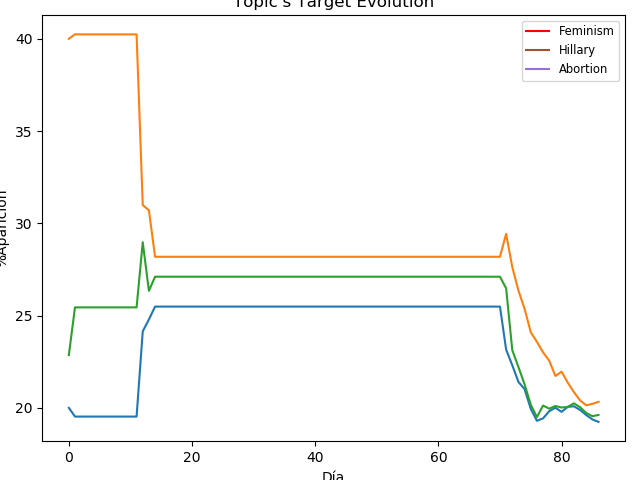

In [101]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt; plt.rcdefaults()

x = np.linspace(0, 86, 87)
y = np.asarray([ath,clim,trump,fem,hill,abor])

plt.plot(x,ath,x,clim,x,trump)

plt.tight_layout()
leg = plt.gca().legend(('Atheism','ClimateChange','Trump','Feminism','Hillary','Abortion'),fontsize = 'small')

LH = leg.legendHandles
LH[0].set_color('red')
LH[1].set_color('sienna')
LH[2].set_color('mediumpurple')
LH[3].set_color('orange')
LH[4].set_color('royalblue')
LH[5].set_color('forestgreen')

plt.xlabel("Día")
plt.ylabel("%Aparición")
plt.title("Topic's Target Evolution")
plt.show()
plt.savefig('prueba1.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


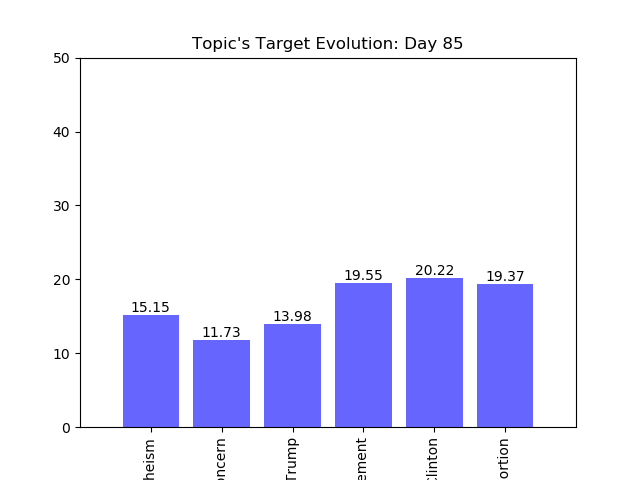

In [113]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.rcParams['animation.ffmpeg_path'] = './anaconda3/bin/ffmpeg'

# set up figure and animation
fig = plt.figure()
plt.axes(xlim=(0, 7), ylim=(0, 50))

objects = list_of_df[1]["index"]
y_pos = np.arange(1,len(list_of_df[1])+1)
percent = list_of_df[1]["P"]
call_bar = plt.bar(y_pos,percent,align='center',alpha=0.6,color='b')
plt.xticks(y_pos, objects, rotation='vertical')
ann_list = []

def animate(i):
    for j,a in enumerate(ann_list):
        a.remove()
    ann_list[:] = []
    
    new_percent = list_of_df[i]["P"]
    plt.title("Topic's Target Evolution: Day "+str(i))
    for rect, y in zip(call_bar, new_percent):
        rect.set_height(y)

    for rect in call_bar:
        height = rect.get_height()
        ann=plt.text(rect.get_x() + rect.get_width()/2.0, height, "{0:.4g}".format(height), ha='center', va='bottom')
        ann_list.append(ann)
    return call_bar

anim = animation.FuncAnimation(fig,animate,frames=len(list_of_df)-1,interval=500,blit=True,repeat=False)
FFwriter=animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('basic_animation.mp4', writer=FFwriter)

<IPython.core.display.Javascript object>


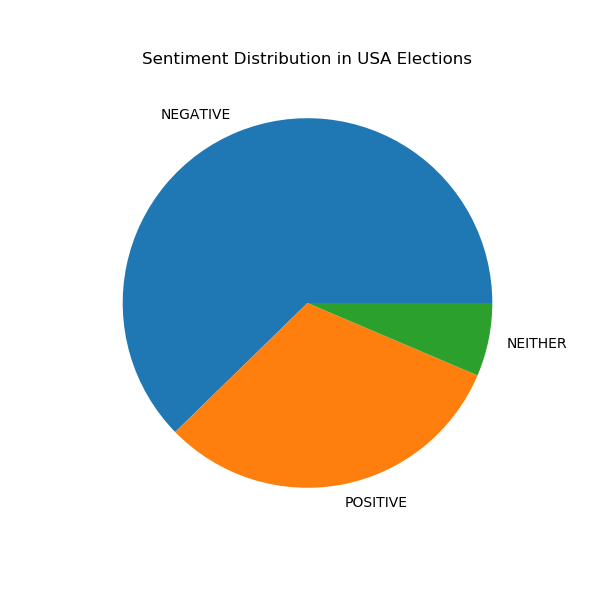

In [75]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt; plt.rcdefaults()
df_usa['Sentiment'].value_counts().plot(kind='pie', title="Sentiment Distribution in USA Elections", figsize=(6,6))
plt.ylabel("")
plt.show()
plt.savefig('SentimentDistr.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


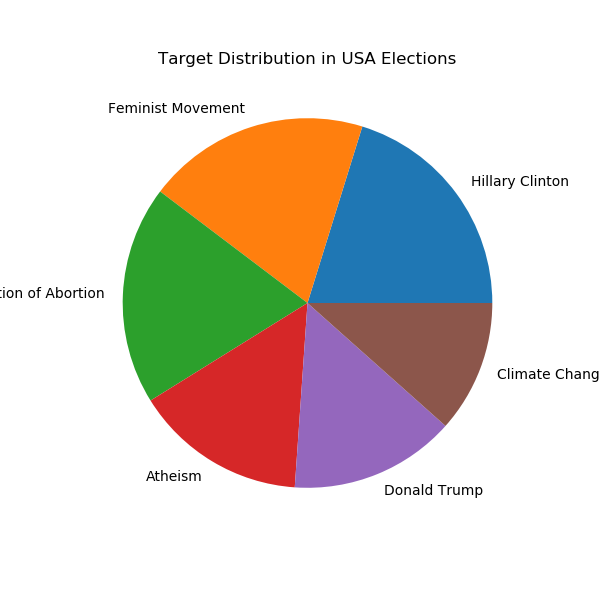

In [74]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt; plt.rcdefaults()
df_usa['Target'].value_counts().plot(kind='pie', title="Target Distribution in USA Elections", figsize=(6,6))
plt.ylabel("")
plt.savefig('TargetDistr.png',bbox_inches='tight')

In [17]:
#%matplotlib notebook
#df_usa['Target'].value_counts(normalize=True).mul(100).plot.bar()

## Análisis Dataset de Elecciones USA

##### Limpieza de texto

In [18]:
import re
df_usa["Tweet"]=df_usa["Tweet"].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #Links
df_usa["Tweet"] = df_usa["Tweet"].str.replace("\b(ha)+|l(ol)+\b",'')                 #Risas
df_usa['Tweet'] = df_usa['Tweet'].str.replace('RT', '')                              #RTS
df_usa['Tweet'] = df_usa['Tweet'].str.replace("\'",' ')                              #Eliminamos acortaciones
df_usa["Tweet"] = df_usa["Tweet"].str.replace('\n', ' ')                             #Saltos de linea
df_usa['Tweet'] = df_usa['Tweet'].str.replace('\d+', '')                             #Numeros
df_usa['Tweet'] = df_usa['Tweet'].str.replace('º', '')
df_usa['Tweet'] = df_usa['Tweet'].str.replace('_', '')
df_usa['Tweet'] = df_usa['Tweet'].str.replace('[^\w\s#@]',' ')                       #Eliminar puntuaciones pero NO los "#", ni "@" 
df_usa["Tweet"]=df_usa["Tweet"].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1', x))      #Eliminar multiples letras consecutivas
df_usa['Tweet'] = df_usa['Tweet'].str.replace('  ',' ').str.lstrip()
#df_new['text'] = df_new['text'].str.lower() #Si hacemos LowC, SpaCy no reconoce entidades!

##### Remove StopWords + POS-TAGGER

In [16]:
import spacy
from nltk.corpus import stopwords
nlp = spacy.load('en_core_web_sm')#,parser=False
stop = stopwords.words('english')+["theyre","im","youre","hes","shes","its","thats"]+["THATS","THEYRE","IM","YOURE","HES","SHES","ITS"]
for i in stop:
    nlp.vocab[i].is_stop = True
#STOP_WORDS.add("your_additional_stop_word_here")
    
nlp.vocab["#"].is_punct = False
nlp.vocab["@"].is_punct = False

from spacy.attrs import ORTH, LEMMA, TAG, ENT_TYPE
nlp.tokenizer.add_special_case("makes", [{ORTH: "makes",LEMMA:"make",TAG:"VERB"}])
nlp.tokenizer.add_special_case("make", [{ORTH: "make",LEMMA:"make",TAG:"VERB"}])
nlp.tokenizer.add_special_case("MAKE", [{ORTH: "make",LEMMA:"make",TAG:"VERB"}])
nlp.tokenizer.add_special_case("dear", [{ORTH: "dear",LEMMA:"dear",TAG:"ADJ"}])
nlp.tokenizer.add_special_case("Dear", [{ORTH: "dear",LEMMA:"dear",TAG:"ADJ"}])
nlp.tokenizer.add_special_case("DEAR", [{ORTH: "dear",LEMMA:"dear",TAG:"ADJ"}])
nlp.tokenizer.add_special_case("gotta", [{ORTH: "got",LEMMA:"got",TAG:"VERB"}])
nlp.tokenizer.add_special_case("feminism", [{ORTH: "feminism",LEMMA:"feminism",TAG:"PROPN",ENT_TYPE:""}])
#matcher = Matcher(nlp.vocab)
#matcher.add('HASHTAG', None, [{'ORTH': '#'}, {'IS_ASCII': True}])
#matcher.add('USER', None, [{'ORTH': '@'}, {'IS_ASCII': True}])

In [12]:
def spacy_text(text):
    doc=nlp(text)
    idx = [m.span() for m in re.finditer('#\w+|@\w+',text,flags=re.IGNORECASE)]
    for start,end in idx:
        doc.merge(start_idx=start,end_idx=end)
    return doc

In [13]:
def twitter_entities(word_text,tag):
    if word_text[0]=="@":
        tag = "USER"
    elif word_text[0]=="#":
        tag = "HASHTAG"
    return tag

In [14]:
def text_tagger(text):
    doc_text=spacy_text(text)
    words = [t.text for t in doc_text if (len(t.text)>=3 and not t.is_stop)]  #antes 2
    postag = [t.pos_ for t in doc_text if (len(t.text)>=3 and not t.is_stop)] #antes 2
    for i,word in enumerate(words):
        postag[i]=twitter_entities(word,postag[i])
    return " ".join(words).replace('  ',' ').lstrip(), postag

In [23]:
df_usa['Analyzed_Tweet'],df_usa['Tweet_LO_PosTag'] = zip(*df_usa['Tweet'].map(text_tagger))
df_usa.head(1000)

ID                            Target  \
0   2015-04-15 18:53:06.259  Hillary Clinton                    
1   2015-04-15 18:53:09.828  Hillary Clinton                    
2   2015-04-15 18:53:24.847  Hillary Clinton                    
3   2015-04-15 18:53:53.254  Hillary Clinton                    
4   2015-04-15 18:54:59.903  Hillary Clinton                    
5   2015-04-15 18:56:05.749  Hillary Clinton                    
6   2015-04-15 18:56:10.221  Feminist Movement                  
7   2015-04-15 18:56:46.964  Hillary Clinton                    
8   2015-04-15 18:57:22.118  Atheism                            
9   2015-04-15 19:00:01.823  Atheism                            
10  2015-04-15 19:01:53.466  Atheism                            
11  2015-04-15 19:01:58.110  Feminist Movement                  
12  2015-04-15 19:08:18.326  Hillary Clinton                    
13  2015-04-15 19:20:13.487  Atheism                            
14  2015-04-15 19:25:03.447  Atheism                            
15  2015-04-15 19:25:30.048  Feminist Movement                  
16  2015-04-15 19:27:58.756  Feminist Movement                  
17  2015-04-15 19:30:13.158  Atheism                            
18  2015-04-15 19:31:02.269  Atheism                            
19  2015-04-15 19:32:12.593  Legalization of Abortion           
20  2015-04-15 19:35:08.213  Hillary Clinton                    
21  2015-04-15 19:35:17.949  Legalization of Abortion           
22  2015-04-15 19:36:07.245  Legalization of Abortion           
23  2015-04-15 19:41:38.942  Feminist Movement                  
24  2015-04-15 19:42:26.811  Hillary Clinton                    
25  2015-04-15 19:43:08.488  Legalization of Abortion           
26  2015-04-15 19:45:32.496  Feminist Movement                  
27  2015-04-15 19:46:30.375  Hillary Clinton                    
28  2015-04-15 19:47:15.780  Hillary Clinton                    
29  2015-04-15 19:47:50.867  Hillary Clinton                    
30  2015-04-15 19:49:16.604  Feminist Movement                  
31  2015-04-15 20:00:22.662  Atheism                            
32  2015-04-15 20:03:40.465  Atheism                            
33  2015-04-15 20:05:32.618  Feminist Movement                  
34  2015-04-15 20:09:27.868  Hillary Clinton                    
35  2015-04-15 20:09:32.941  Hillary Clinton                    
36  2015-04-15 20:13:42.091  Atheism                            
37  2015-04-15 20:33:21.432  Hillary Clinton                    
38  2015-04-15 20:34:51.410  Legalization of Abortion           
39  2015-04-15 20:39:40.358  Atheism                            
40  2015-04-15 20:42:09.547  Legalization of Abortion           
41  2015-04-15 20:45:09.046  Feminist Movement                  
42  2015-04-15 20:45:10.441  Legalization of Abortion           
43  2015-04-15 20:48:18.493  Hillary Clinton                    
44  2015-04-15 20:48:25.819  Hillary Clinton                    
45  2015-04-15 20:50:37.580  Legalization of Abortion           
46  2015-04-15 20:53:22.990  Hillary Clinton                    
47  2015-04-15 20:56:39.084  Legalization of Abortion           
48  2015-04-15 20:59:21.556  Legalization of Abortion           
49  2015-04-15 21:00:11.272  Legalization of Abortion           
50  2015-04-15 21:01:54.266  Legalization of Abortion           
51  2015-04-15 21:02:30.642  Legalization of Abortion           
52  2015-04-15 21:09:30.107  Hillary Clinton                    
53  2015-04-15 21:12:33.641  Hillary Clinton                    
54  2015-04-15 21:16:01.690  Hillary Clinton                    
55  2015-04-15 21:27:30.178  Hillary Clinton                    
56  2015-04-15 21:33:02.383  Legalization of Abortion           
57  2015-04-15 21:35:38.497  Hillary Clinton                    
58  2015-04-15 21:36:56.600  Feminist Movement                  
59  2015-04-15 21:38:34.836  Hillary Clinton                    
60  2015-04-15 21:39:35.691  Legalization of Abortion       

##### Lematization

In [24]:
def text_lemmatizer(text,text_tags):
    doc_text=spacy_text(text)
    lemma = [t.lemma_ if text_tags[t.i] not in ["USER","HASHTAG"] else t.orth_ for t in doc_text]
    return " ".join(lemma).replace('  ',' ').lstrip(),lemma

In [25]:
df_usa['Analyzed_Tweet'],df_usa['Tweet_LO_Text'] = zip(*df_usa.apply(lambda x: text_lemmatizer(x['Analyzed_Tweet'],x['Tweet_LO_PosTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                  Analyzed_Tweet  \
0  ceo pay target election make CEO drank Kool Aid                                                 
1  @GunnJessica want young american woman able proud woman president #SemST                        
2  @readyforHRC @HillaryClinton #HillaryClinton presidency testament success #women role world     
3  @Chris @newsbusters year ago #Hillary answer private email #Liberal medium pass report #SemST   
4  edge seat start volunteer @HillaryClinton presidential campaign excite #cantwait                

                                                                         Tweet_LO_PosTag  \
0  [NOUN, VERB, NOUN, NOUN, , PROPN, VERB, PROPN, PROPN]                                   
1  [USER, VERB, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]                             
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]                            
3  [USER, USER, NOUN, ADV, HASHTAG, VERB, ADJ, NOUN, HASHTAG, NOUN, VERB, VERB, HASHTAG]   
4  [NOUN, NOUN, VERB, VERB, USER, ADJ, NOUN, ADJ, HASHTAG]                                 

                                                                                                 Tweet_LO_Text  
0  [ceo, pay, target, election, make, CEO, drank, Kool, Aid]                                                    
1  [@GunnJessica, want, young, american, woman, able, proud, woman, president, #SemST]                          
2  [@readyforHRC, @HillaryClinton, #HillaryClinton, presidency, testament, success, #women, role, world]        
3  [@Chris, @newsbusters, year, ago, #Hillary, answer, private, email, #Liberal, medium, pass, report, #SemST]  
4  [edge, seat, start, volunteer, @HillaryClinton, presidential, campaign, excite, #cantwait]

##### Eliminar elementos no-útiles

In [26]:
def simplif_text(text_list,text_tag):
    for i,tag in sorted(enumerate(text_tag),reverse=True):
        if tag not in ("NOUN", "PROPN", "ADJ" ,"USER", "HASHTAG"):
            del text_tag[i]
            del text_list[i]
    return " ".join(text_list).replace('  ',' ').lstrip(),text_list,text_tag

In [27]:
df_usa['Analyzed_Tweet'],df_usa['Tweet_LO_Text'],df_usa['Tweet_LO_PosTag'] = zip(*df_usa.apply(lambda x: simplif_text(x['Tweet_LO_Text'],x['Tweet_LO_PosTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                Analyzed_Tweet  \
0  ceo target election CEO Kool Aid                                                              
1  @GunnJessica young american woman able proud woman president #SemST                           
2  @readyforHRC @HillaryClinton #HillaryClinton presidency testament success #women role world   
3  @Chris @newsbusters year #Hillary private email #Liberal medium #SemST                        
4  edge seat @HillaryClinton presidential campaign excite #cantwait                              

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                           Tweet_LO_Text  
0  [ceo, target, election, CEO, Kool, Aid]                                                                
1  [@GunnJessica, young, american, woman, able, proud, woman, president, #SemST]                          
2  [@readyforHRC, @HillaryClinton, #HillaryClinton, presidency, testament, success, #women, role, world]  
3  [@Chris, @newsbusters, year, #Hillary, private, email, #Liberal, medium, #SemST]                       
4  [edge, seat, @HillaryClinton, presidential, campaign, excite, #cantwait]

##### Lowecase + Acentos

In [28]:
import unicodedata
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore').decode("utf-8") 
    return only_ascii

In [29]:
df_usa['Analyzed_Tweet'] = df_usa['Analyzed_Tweet'].str.lower()
df_usa['Tweet_LO_Text'] = df_usa['Tweet_LO_Text'].map(lambda x: [item.lower() for item in x])
df_usa['Analyzed_Tweet'] = df_usa['Analyzed_Tweet'].map(remove_accents)

#### Formato fecha

In [5]:
from datetime import datetime
def date_format(input_date):
    output_date = datetime.strptime(input_date,'%Y-%m-%d %H:%M:%S.%f') #2019-07-15 09:13:18.000'
    if int(output_date.hour) in range(7,15):
        part_day="Morning"
    elif int(output_date.hour) in range(14,21):
        part_day="Afternoon"
    else:
        part_day="Night"
    return part_day

In [31]:
df_usa["PartDay"] = df_usa['ID'].map(date_format)
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                              
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world   
3  @chris @newsbusters year #hillary private email #liberal medium #semst                        
4  edge seat @hillaryclinton presidential campaign excite #cantwait                              

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                           Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                                 
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, #hillary, private, email, #liberal, medium, #semst]                        
4  [edge, seat, @hillaryclinton, presidential, campaign, excite, #cantwait]                                

   Day  Month       Date  
0  15   4      4-15-2015  
1  15   4      4-15-2015  
2  15   4      4-15-2015  
3  15   4      4-15-2015  
4  15   4      4-15-2015

### N_GRAMS

In [32]:
from nltk import ngrams
from collections import Counter

#Buscar N-gramas frecuentes, considerarlos en el texto
def grams_remove(old_text,old_tagpos,gram_list,gram_len):
    length=len(old_text)
    new_text=old_text[:]
    new_tagpos = old_tagpos[:]
    rem_idx=[]
    for gram in gram_list:
        for i in range(0,length+1-gram_len):
            if tuple(new_text[i:i+gram_len]) == gram:
                new_text[i]="_".join(gram)
                new_tagpos[i]="NGRAM"
                for k in range(i+1,i+gram_len):
                    rem_idx.append(k)
    for idx in sorted(rem_idx, reverse=True):
        del new_text[idx]
        del new_tagpos[idx]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text, new_tagpos

In [33]:
#Eliminar grams acabados con un hashtag. 
#Suelen repetirse mucho y no tiene porqué ser una entidad
def rem_hashgrams(list_gram):
    rem_idx=[]
    for i in range(0,len(list_gram)):
        if list_gram[i][0][-1][0] == "#":
            rem_idx.append(i)
    for j in sorted(rem_idx,reverse=True):
        del list_gram[j]
    return list_gram

#### 3-grams

In [34]:
trigram_list = [pair for row in df_usa['Tweet_LO_Text'] for pair in ngrams(row, 3)] 
tricounts = (Counter(trigram_list).most_common(200))
count_trigrams=pd.DataFrame.from_records(tricounts, columns=['gram', 'count'])
count_trigrams=count_trigrams[count_trigrams["count"]>3]
count_trigrams.head(100)
count_trigrams=count_trigrams.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43])
count_trigrams.head(100)
list_trigram=count_trigrams["gram"].tolist()
list_trigram

/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'ngrams' raised StopIteration
  """Entry point for launching an IPython kernel.


[('anti', 'choice', 'law')]

In [35]:
df_usa["Analyzed_Tweet"],df_usa["Tweet_LO_Text"],df_usa['Tweet_LO_PosTag'] = zip(*df_usa.apply(lambda x: grams_remove(x['Tweet_LO_Text'],x['Tweet_LO_PosTag'], list_trigram,3), axis=1))

#### 2-grams

In [36]:
bigram_list = [pair for row in df_usa['Tweet_LO_Text'] for pair in ngrams(row, 2)]
bicounts = rem_hashgrams(Counter(bigram_list).most_common(200))
count_bigrams=pd.DataFrame.from_records(bicounts, columns=['gram', 'count'])
count_bigrams=count_bigrams[count_bigrams["count"]>3]
count_bigrams=count_bigrams.drop([3,8,9,11,12,15,16,19,20,21,22,23,26,28,29,30,32,33,34,35,36,39,41,42,43,44,45,46,47,48,49,51,52,53,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72])
count_bigrams.head(50)

/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'ngrams' raised StopIteration
  """Entry point for launching an IPython kernel.


gram  count
0   (donald, trump)        50   
1   (climate, change)      39   
2   (hillary, clinton)     37   
4   (woman, right)         22   
5   (pro, life)            20   
6   (equal, right)         18   
7   (white, house)         16   
10  (pro, choice)          14   
13  (human, right)         13   
14  (global, warming)      12   
17  (unborn, child)        11   
18  (gay, marriage)        10   
24  (supreme, court)       9    
25  (united, states)       9    
27  (birth, control)       8    
31  (marriage, equality)   7    
37  (confederate, flag)    7    
38  (sea, level)           7    
40  (david, attenborough)  7    
50  (human, being)         6    
54  (social, medium)       6    
55  (mother, teresa)       6    
67  (death, penalty)       5

In [37]:
list_bigram=count_bigrams["gram"].tolist()+[("preborn","child"),("gender","equality")]
list_bigram

[('donald', 'trump'),
 ('climate', 'change'),
 ('hillary', 'clinton'),
 ('woman', 'right'),
 ('pro', 'life'),
 ('equal', 'right'),
 ('white', 'house'),
 ('pro', 'choice'),
 ('human', 'right'),
 ('global', 'warming'),
 ('unborn', 'child'),
 ('gay', 'marriage'),
 ('supreme', 'court'),
 ('united', 'states'),
 ('birth', 'control'),
 ('marriage', 'equality'),
 ('confederate', 'flag'),
 ('sea', 'level'),
 ('david', 'attenborough'),
 ('human', 'being'),
 ('social', 'medium'),
 ('mother', 'teresa'),
 ('death', 'penalty'),
 ('preborn', 'child'),
 ('gender', 'equality')]

In [38]:
df_usa["Analyzed_Tweet"],df_usa["Tweet_LO_Text"],df_usa['Tweet_LO_PosTag'] = zip(*df_usa.apply(lambda x: grams_remove(x['Tweet_LO_Text'],x['Tweet_LO_PosTag'], list_bigram,2), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                              
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world   
3  @chris @newsbusters year #hillary private email #liberal medium #semst                        
4  edge seat @hillaryclinton presidential campaign excite #cantwait                              

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                           Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                                 
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, #hillary, private, email, #liberal, medium, #semst]                        
4  [edge, seat, @hillaryclinton, presidential, campaign, excite, #cantwait]                                

   Day  Month       Date  
0  15   4      4-15-2015  
1  15   4      4-15-2015  
2  15   4      4-15-2015  
3  15   4      4-15-2015  
4  15   4      4-15-2015

#### Unify Entities

In [39]:
def unify_ent(old_text,diccionary):
    new_text = old_text[:]
    for i in range(0,len(old_text)):
        if old_text[i] in diccionary:
            new_text[i]=diccionary[old_text[i]][0]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text

In [40]:
trump = ["@realdonaldtrump","donald_trump","mr_trump","trump","#trump","donald","#donaldtrump","donaldtrump"]
dic_trump= dict.fromkeys(trump, "donald_trump")
hillary = ["@hillaryclinton","#hillaryclinton","hillaryclinton","hillary","clinton","hilary","#stophillary","#stophillarypac","hillary_clinton","#hillary","killary","#killary","nohillary","#nohillary","#readyforhillary","readyforhillary"]
dic_hillary= dict.fromkeys(hillary, "hillary_clinton")
democrats=["@thedemocrats","@vademocrats","democrats","democrat","#democrats","#democrat"]
dic_dem =  dict.fromkeys(democrats, "democrat")
republican= ["republican","republicans","#republican","#republicans", "#republicanvalues"]
dic_rep = dict.fromkeys(republican,"republican")
obama = ["#obama","obama","@barackobama","barackobama"]
dic_obama=dict.fromkeys(obama,"barack_obama")
usa = ["#unitedstates","united_states","usa","@unitedstates"]
dic_usa = dict.fromkeys(usa,"USA")
scotus = ["#scotus","scotus","supreme_court","supremecourt","#supremecourt"]
dic_scotus = dict.fromkeys(scotus,"SCOTUS")
davidatt = ["@sir_attenboroug","david_attenboroug","attenborough","davidattenboroug"]
dic_david= dict.fromkeys(davidatt, "david_attenboroug")
chris = ["îchristopher"]
dic_chris = dict.fromkeys(chris,"christopher")
dicts = [dic_trump,dic_hillary,dic_usa,dic_david,dic_chris,dic_scotus,dic_obama,dic_dem,dic_rep]
super_dict = {}
for d in dicts:
    for k, v in d.items():
        super_dict.setdefault(k, []).append(v)

In [41]:
df_usa["Analyzed_Tweet"],df_usa["Tweet_LO_Text"] = zip(*df_usa.apply(lambda x: unify_ent(x['Tweet_LO_Text'],super_dict), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                              
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc hillary_clinton hillary_clinton presidency testament success #women role world   
3  @chris @newsbusters year hillary_clinton private email #liberal medium #semst                 
4  edge seat hillary_clinton presidential campaign excite #cantwait                              

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                           Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                                 
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, hillary_clinton, private, email, #liberal, medium, #semst]                 
4  [edge, seat, hillary_clinton, presidential, campaign, excite, #cantwait]                                

   Day  Month       Date  
0  15   4      4-15-2015  
1  15   4      4-15-2015  
2  15   4      4-15-2015  
3  15   4      4-15-2015  
4  15   4      4-15-2015

#### Hashtags normalization

In [42]:
#Parece lógico eliminar el símbolo de usuarios y hashtags para considerar posibles coincidencias entre terminos
def tweet_lemmatizer(text_list,text_tags):
    new_text = text_list[:]
    for i,word in enumerate(text_list):
            new_text[i] = word.replace('#','').replace('@','')   
    doc_text=spacy_text(" ".join(new_text).replace('  ',' ').lstrip())
    lemma = [t.lemma_ if text_tags[t.i] not in ["USER","GRAM"] else t.orth_ for t in doc_text]
    return " ".join(lemma).replace('  ',' ').lstrip(),lemma

In [43]:
df_usa['Analyzed_Tweet'],df_usa['Tweet_LO_Text'] = zip(*df_usa.apply(lambda x: tweet_lemmatizer(x['Tweet_LO_Text'],x['Tweet_LO_PosTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                              Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                            
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign excite cantwait                             

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                         Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                               
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, excite, cantwait]                               

   Day  Month       Date  
0  15   4      4-15-2015  
1  15   4      4-15-2015  
2  15   4      4-15-2015  
3  15   4      4-15-2015  
4  15   4      4-15-2015

#### Grams Normalization

In [44]:
gram_list = ["_".join(gram) for gram in list_bigram+list_trigram]
text_list = ["".join(gram) for gram in list_bigram+list_trigram]
gramtionary = dict(zip(text_list, gram_list))

In [45]:
def unify_hashent(old_text,diccionary):
    new_text = old_text[:]
    for i in range(0,len(old_text)):
        if old_text[i] in diccionary:
            new_text[i]=diccionary[old_text[i]]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text

In [46]:
df_usa["Analyzed_Tweet"],df_usa["Tweet_LO_Text"] = zip(*df_usa.apply(lambda x: unify_hashent(x['Tweet_LO_Text'],gramtionary), axis=1))
df_usa.head(10000)

ID                            Target  \
0    2015-04-15 18:53:06.259  Hillary Clinton                    
1    2015-04-15 18:53:09.828  Hillary Clinton                    
2    2015-04-15 18:53:24.847  Hillary Clinton                    
3    2015-04-15 18:53:53.254  Hillary Clinton                    
4    2015-04-15 18:54:59.903  Hillary Clinton                    
5    2015-04-15 18:56:05.749  Hillary Clinton                    
6    2015-04-15 18:56:10.221  Feminist Movement                  
7    2015-04-15 18:56:46.964  Hillary Clinton                    
8    2015-04-15 18:57:22.118  Atheism                            
9    2015-04-15 19:00:01.823  Atheism                            
10   2015-04-15 19:01:53.466  Atheism                            
11   2015-04-15 19:01:58.110  Feminist Movement                  
12   2015-04-15 19:08:18.326  Hillary Clinton                    
13   2015-04-15 19:20:13.487  Atheism                            
14   2015-04-15 19:25:03.447  Atheism                            
15   2015-04-15 19:25:30.048  Feminist Movement                  
16   2015-04-15 19:27:58.756  Feminist Movement                  
17   2015-04-15 19:30:13.158  Atheism                            
18   2015-04-15 19:31:02.269  Atheism                            
19   2015-04-15 19:32:12.593  Legalization of Abortion           
20   2015-04-15 19:35:08.213  Hillary Clinton                    
21   2015-04-15 19:35:17.949  Legalization of Abortion           
22   2015-04-15 19:36:07.245  Legalization of Abortion           
23   2015-04-15 19:41:38.942  Feminist Movement                  
24   2015-04-15 19:42:26.811  Hillary Clinton                    
25   2015-04-15 19:43:08.488  Legalization of Abortion           
26   2015-04-15 19:45:32.496  Feminist Movement                  
27   2015-04-15 19:46:30.375  Hillary Clinton                    
28   2015-04-15 19:47:15.780  Hillary Clinton                    
29   2015-04-15 19:47:50.867  Hillary Clinton                    
30   2015-04-15 19:49:16.604  Feminist Movement                  
31   2015-04-15 20:00:22.662  Atheism                            
32   2015-04-15 20:03:40.465  Atheism                            
33   2015-04-15 20:05:32.618  Feminist Movement                  
34   2015-04-15 20:09:27.868  Hillary Clinton                    
35   2015-04-15 20:09:32.941  Hillary Clinton                    
36   2015-04-15 20:13:42.091  Atheism                            
37   2015-04-15 20:33:21.432  Hillary Clinton                    
38   2015-04-15 20:34:51.410  Legalization of Abortion           
39   2015-04-15 20:39:40.358  Atheism                            
40   2015-04-15 20:42:09.547  Legalization of Abortion           
41   2015-04-15 20:45:09.046  Feminist Movement                  
42   2015-04-15 20:45:10.441  Legalization of Abortion           
43   2015-04-15 20:48:18.493  Hillary Clinton                    
44   2015-04-15 20:48:25.819  Hillary Clinton                    
45   2015-04-15 20:50:37.580  Legalization of Abortion           
46   2015-04-15 20:53:22.990  Hillary Clinton                    
47   2015-04-15 20:56:39.084  Legalization of Abortion           
48   2015-04-15 20:59:21.556  Legalization of Abortion           
49   2015-04-15 21:00:11.272  Legalization of Abortion           
50   2015-04-15 21:01:54.266  Legalization of Abortion           
51   2015-04-15 21:02:30.642  Legalization of Abortion           
52   2015-04-15 21:09:30.107  Hillary Clinton                    
53   2015-04-15 21:12:33.641  Hillary Clinton                    
54   2015-04-15 21:16:01.690  Hillary Clinton                    
55   2015-04-15 21:27:30.178  Hillary Clinton                    
56   2015-04-15 21:33:02.383  Legalization of Abortion           
57   2015-04-15 21:35:38.497  Hillary Clinton                    
58   2015-04-15 21:36:56.600  Feminist Movement                  
59   2015-04-15 21:38:34.836  Hillary Clinton                    


#### Terms Grouping

In [51]:
prolife = ["prolife","pro_life","prolifegen","prolifeyouth","alllivesmatter"]
dic_prolife= dict.fromkeys(prolife, "prolife")
prochoice = ["prochoice","pro_choice","prowomanchoice"]
dic_prochoice= dict.fromkeys(prochoice, "prochoice")
feminist = ["feminist","feminism","genderequality","gender_equality"]
dic_fem= dict.fromkeys(feminist, "feminism")
antifeminist = ["antifeminism","antifeminist","feminazi","spankafeminist","notafeminist","meninist"]
dic_antifem= dict.fromkeys(antifeminist, "antifeminism")
racism = ["racist","racism"]
dic_rac = dict.fromkeys(racism, "racism")
latin = ["latino","inmigration","immigration", "hispanic","immigrant"]
dic_latin = dict.fromkeys(latin, "immigrant")
mexico= ["mexicanpeople","mexican","wearemexico","mexico"]
dic_mexico = dict.fromkeys(mexico, "mexicanpeople")
baby = ["baby","child","kid"]
dic_baby = dict.fromkeys(baby, "child")
fetus = ["fetus","unborn_child","unborn","preborn","preborn_child"]
dic_fetus = dict.fromkeys(fetus, "unbornchild")
pregn = ["pregnant","pregnancy"]
dic_pregn = dict.fromkeys(pregn, "pregnant")
equalmarriage = ["marriageequality","marriage_equality","marriageequaility"]
dic_eqmarr = dict.fromkeys(equalmarriage, "marriageequality")
gaymarriage = ["#scotusmarriage","scotusmarriage","gaymarriage","gay_marriage","scotusmarriage"]
dic_gaymarr = dict.fromkeys(gaymarriage, "gaymarriage")
equality = ["#equalityforall","equalityforall","equality","equal_right","equalright","eaquality"]
dic_eqq = dict.fromkeys(equality, "equality")
woman = ["womensright","woman_right"]
dic_wr = dict.fromkeys(woman, "woman_right")
rape = ["rape","rapeculture","rapist","maritalrape","maritalrapedebate"]
dic_rape = dict.fromkeys(rape, "rape")
islam = ["islamicstate","islamic","isis","islam"]
dic_islam= dict.fromkeys(islam, "islam")
climatic = ["climate_change","climatechange","climate","climatenexus","climatehope","emission","ecologyaction","global_warming","globalwarming","climatechangeisreal","mychangeforclimate"]
dic_clim = dict.fromkeys(climatic, "climate_change")
lgbt = ["lgbt","gay","lesbian","homosex","homosexual","homosexuality"]
dic_lgbt = dict.fromkeys(lgbt,"lgbt")
anti=["antichoice","anti_choice_law","antichoicelaw"]
dic_antic = dict.fromkeys(anti,"anti_choice_law")
cathol=["catholic","romancatholic","church","christian","christ","christianity","bible","jesus","teamjesus"]
dic_cathol = dict.fromkeys(cathol,"catholic")
atheos=["agnostic","atheism","atheistq","atheist","atheists"]
dic_atheos = dict.fromkeys(atheos,"atheism")
liberty = ["liberty","freedom"]
dic_liberty = dict.fromkeys(liberty,"freedom")
science= ["science", "sciencerule","scientist"]
dic_science = dict.fromkeys(science,"science")
misogyny= ["misogyny", "misogynism", "misogynst","misogynyisugly","misogynist","misogynistic"]
dic_misogyny = dict.fromkeys(misogyny,"misogyny")
sexism= ["sexism", "sexist"]
dic_sexism = dict.fromkeys(sexism,"sexism")
woman= ["woman", "yesallwomen","yesallwoman", "female", "girl"]
dic_woman = dict.fromkeys(woman,"woman")
man= ["man", "male"]
dic_man = dict.fromkeys(man,"man")

dicts = [dic_prolife,dic_prochoice,dic_fem,dic_antifem,dic_rac,dic_latin,dic_mexico,dic_baby,dic_fetus,dic_pregn,dic_eqmarr,dic_gaymarr,dic_eqq,dic_wr,dic_rape,dic_islam,dic_clim,dic_lgbt,dic_antic,dic_cathol,dic_atheos,dic_liberty,dic_science,dic_misogyny,dic_sexism,dic_woman,dic_man]
terms_dict = {}
for d in dicts:
    for k, v in d.items():
        terms_dict.setdefault(k, []).append(v)

In [52]:
df_usa["Analyzed_Tweet"],df_usa["Tweet_LO_Text"] = zip(*df_usa.apply(lambda x: unify_ent(x['Tweet_LO_Text'],terms_dict), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                              Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                            
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign excite cantwait                             

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                         Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                               
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, excite, cantwait]                               

   Day  Month       Date  
0  15   4      4-15-2015  
1  15   4      4-15-2015  
2  15   4      4-15-2015  
3  15   4      4-15-2015  
4  15   4      4-15-2015

## Bolsa de Palabras

In [2]:
from collections import Counter
item_list = sum(df_usa.Tweet_LO_Text, [])
item_count = Counter(item_list)
most_common_terms=item_count.most_common(500)
item_count.most_common(500)

[('semst', 4770),
 ('hillary_clinton', 571),
 ('woman', 529),
 ('donald_trump', 387),
 ('feminism', 324),
 ('god', 301),
 ('man', 297),
 ('people', 269),
 ('catholic', 231),
 ('child', 221),
 ('life', 180),
 ('abortion', 178),
 ('good', 158),
 ('time', 157),
 ('right', 129),
 ('day', 128),
 ('world', 120),
 ('equality', 118),
 ('climate_change', 113),
 ('tcot', 112),
 ('prolife', 108),
 ('america', 108),
 ('thing', 102),
 ('great', 99),
 ('president', 98),
 ('way', 98),
 ('barack_obama', 97),
 ('today', 90),
 ('gop', 80),
 ('love', 78),
 ('human', 77),
 ('country', 77),
 ('bad', 76),
 ('gamergate', 75),
 ('year', 69),
 ('law', 69),
 ('rape', 68),
 ('truth', 67),
 ('unbornchild', 64),
 ('SCOTUS', 64),
 ('religion', 63),
 ('new', 60),
 ('american', 59),
 ('potus', 59),
 ('islam', 57),
 ('real', 57),
 ('choice', 56),
 ('wakeupamerica', 54),
 ('pregnant', 54),
 ('lord', 53),
 ('thank', 53),
 ('lgbt', 53),
 ('word', 51),
 ('candidate', 51),
 ('vote', 50),
 ('wrong', 50),
 ('lovewin', 50),
 

In [3]:
bow_list=[1,2,3,4,6,8,9,11,17,18,20,26,36,38,40,44,48,51,57,58,59,61,62,70,76,78,79,83,85,90,93,102,104,107,110,111,127,153,162,166,174,200,206,259,264,287,290,306,412,474]
bow =[most_common_terms[i][0] for i in bow_list] 
#[str(i)+"  "+most_common_terms[i][0] for i in bow_list] 

In [4]:
bow_words = [most_common_terms[i] for i in bow_list] 
topicdic = dict(zip(list(df_usa.Target.unique()), ["hillary_clinton","feminism","atheism","abortion","climate_change","donald_trump"]))

<IPython.core.display.Javascript object>


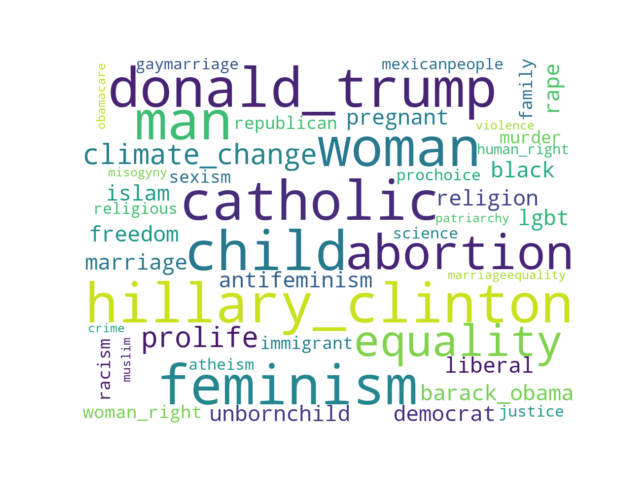

In [64]:
%matplotlib notebook
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

#convert list to string and generate
unique_string=(" ").join(bow)
wordcloud = WordCloud(width = 1000, height = 750,background_color="white",min_font_size = 20).generate(unique_string)
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.savefig('WordCloud.png')

<IPython.core.display.Javascript object>


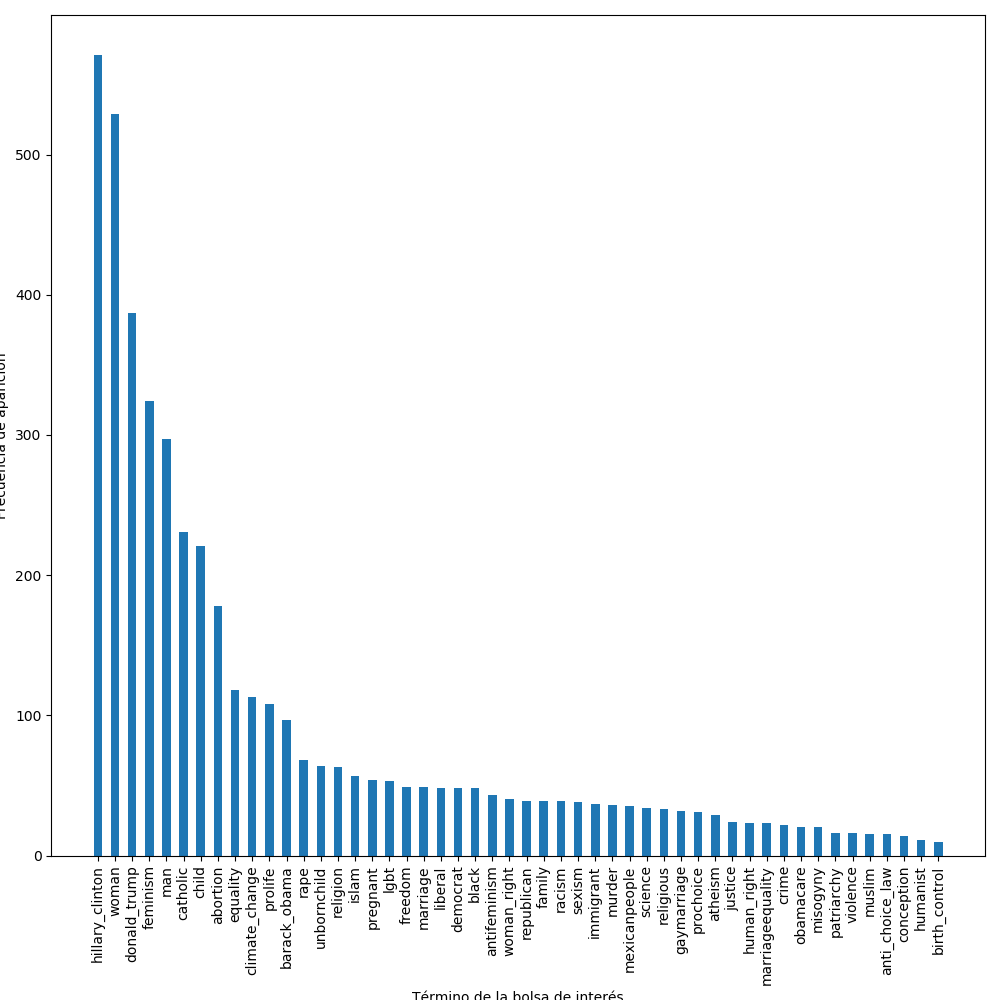

In [65]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

names, values = zip(*bow_words)
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
indexes = np.arange(len(names))
width = 0.5
plt.bar(indexes, values, width)
plt.xticks(indexes, names)
plt.tight_layout()
plt.xlabel("Término de la bolsa de interés")
plt.ylabel("Frecuencia de aparición")
plt.show()
plt.savefig('FreqPlot.png',bbox_inches='tight')

In [66]:
def look_bow_terms(text_list,target,bow_l,target_dict):
    bow_text=[]
    for word in text_list:
        if word in bow_l:
            bow_text.append(word)
    bow_text.append(target_dict[target])
    final_text=list(set(bow_text))
    return final_text#" ".join(final_text).replace('  ',' ').lstrip()

In [67]:
df_usa["BOW_Tweet"] = df_usa.apply(lambda x: look_bow_terms(x['Tweet_LO_Text'],x['Target'],bow,topicdic), axis=1)
df_usa.head(20)

ID                    Target  \
0  2015-04-15 18:53:06.259  Hillary Clinton            
1  2015-04-15 18:53:09.828  Hillary Clinton            
2  2015-04-15 18:53:24.847  Hillary Clinton            
3  2015-04-15 18:53:53.254  Hillary Clinton            
4  2015-04-15 18:54:59.903  Hillary Clinton            
5  2015-04-15 18:56:05.749  Hillary Clinton            
6  2015-04-15 18:56:10.221  Feminist Movement          
7  2015-04-15 18:56:46.964  Hillary Clinton            
8  2015-04-15 18:57:22.118  Atheism                    
9  2015-04-15 19:00:01.823  Atheism                    
10 2015-04-15 19:01:53.466  Atheism                    
11 2015-04-15 19:01:58.110  Feminist Movement          
12 2015-04-15 19:08:18.326  Hillary Clinton            
13 2015-04-15 19:20:13.487  Atheism                    
14 2015-04-15 19:25:03.447  Atheism                    
15 2015-04-15 19:25:30.048  Feminist Movement          
16 2015-04-15 19:27:58.756  Feminist Movement          
17 2015-04-15 19:30:13.158  Atheism                    
18 2015-04-15 19:31:02.269  Atheism                    
19 2015-04-15 19:32:12.593  Legalization of Abortion   

                                                                                                                                       Tweet  \
0   CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                                     
1   @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                                   
2   @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world             
3   @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST             
4   I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                          
5   @dnewhauser take that Marco Rubio @GOP cannot pander to the Latino vote while pushing policies that hurt the community most #SemST         
6   Always a delight to see chest drumming alpha males hiss and scuttle backwards up the wall when a feminist enters the room #manly #SemST    
7   I just gave an unhealthy amount of my hard earned money away to the big gov t untrustworthy IRS #WhyImNotVotingForHillary                  
8   dear lord thank u for all of ur blessings forgive my sins lord give me strength and energy for this busy day ahead #blessed #hope #SemST   
9   Blessed are the peacemakers for they shall be called children of God Matthew #scripture #peace #SemST                                      
10  I am not conformed to this world I am transformed by the renewing of my mind #ISpeakLife #God # #SemST                                     
11  Sometimes I overheat and want to take off my shirt but can t because of social expectations of people with breasts n #SemST                
12  @StateDept @AmbCathyRussell @AdamSmithUSA @HillaryClinton @HillaryforIA @BarackObama The whole #world is supporting you #SemST             
13  Salah should be prayed with #focus and #understanding #Allah warns against #lazy prayers done just for #show Surah Al Maoon #SemST         
14  And stay in your houses and do not display yourselves like that of the times of ignorance Quran #islam #SemST                              
15  If feminists spent as much time reading papers as they do tumblr they would be real people not ignorant sexist bigots #SemST               
16  Stupid Feminists the civilization you take for granted was built with the labour blood sweat and tears of men #SemST                       
17  If we are unsure whether something is halal or haram we should leave it this will #safeguard our #deen #rule #SemST                        
18  Papa God i pray that You shower me with more patience #worththewait #SemST                                 

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 5000)
df_usa = pd.read_csv('./usa_spacy/usa_bow_analyzed.csv',converters={'Tweet_LO_PosTag': eval,'Tweet_LO_Text': eval, 'BOW_Tweet': eval})
del df_usa["Unnamed: 0"]
del df_usa["Day"]
del df_usa["Date"]
del df_usa["Month"]
df_usa["PartDay"] = df_usa['ID'].map(date_format)
df_usa.head()

ID           Target  \
0  2015-04-15 18:53:06.259  Hillary Clinton   
1  2015-04-15 18:53:09.828  Hillary Clinton   
2  2015-04-15 18:53:24.847  Hillary Clinton   
3  2015-04-15 18:53:53.254  Hillary Clinton   
4  2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  CEO pay the target for election From someone who makes more than most CEO s but you drank the Kool Aid                           
1  @GunnJessica Because I want young American women to be able to be proud of the st woman president #SemST                         
2  @readyforHRC @HillaryClinton #HillaryClinton the US presidency is a testament to the success of #women their role in the world   
3  @Chris @newsbusters years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I m on the edge of my seat to start volunteering for @HillaryClinton s presidential campaign So excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                              Analyzed_Tweet  \
0  ceo target election ceo kool aid                                                            
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign excite cantwait                             

                                                  Tweet_LO_PosTag  \
0  [NOUN, NOUN, NOUN, PROPN, PROPN, PROPN]                          
1  [USER, ADJ, ADJ, NOUN, ADJ, ADJ, NOUN, NOUN, HASHTAG]            
2  [USER, USER, HASHTAG, NOUN, NOUN, NOUN, HASHTAG, NOUN, NOUN]     
3  [USER, USER, NOUN, HASHTAG, ADJ, NOUN, HASHTAG, NOUN, HASHTAG]   
4  [NOUN, NOUN, USER, ADJ, NOUN, ADJ, HASHTAG]                      

                                                                                         Tweet_LO_Text  \
0  [ceo, target, election, ceo, kool, aid]                                                               
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, excite, cantwait]                               

                    BOW_Tweet    PartDay  
0  [hillary_clinton]           Afternoon  
1  [woman, hillary_clinton]    Afternoon  
2  [woman, hillary_clinton]    Afternoon  
3  [liberal, hillary_clinton]  Afternoon  
4  [hillary_clinton]           Afternoon

In [7]:
df_usa.to_csv("usa_bow_analyzed.csv")

### Fuzzy-CSar

In [9]:
df_usa_cs = pd.concat([df_usa["PartDay"],df_usa["BOW_Tweet"],df_usa["Sentiment"].str.lower()] ,axis=1, keys=['Date', 'BOW_Tweet', 'Sentiment'])
df_usa_cs.head()

Date                   BOW_Tweet Sentiment
0  Afternoon  [hillary_clinton]           negative
1  Afternoon  [woman, hillary_clinton]    positive
2  Afternoon  [woman, hillary_clinton]    positive
3  Afternoon  [liberal, hillary_clinton]  negative
4  Afternoon  [hillary_clinton]           positive

In [10]:
df_usa_csar = df_usa_cs.drop('BOW_Tweet', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_usa_cs.BOW_Tweet.tolist()).stack()
    ).astype(int).sum(level=0)
)
df_usa_csar.head()

Date Sentiment  abortion  anti_choice_law  antifeminism  atheism  \
0  Afternoon  negative  0         0                0             0         
1  Afternoon  positive  0         0                0             0         
2  Afternoon  positive  0         0                0             0         
3  Afternoon  negative  0         0                0             0         
4  Afternoon  positive  0         0                0             0         

   barack_obama  birth_control  black  catholic  ...  rape  religion  \
0  0             0              0      0         ...  0     0          
1  0             0              0      0         ...  0     0          
2  0             0              0      0         ...  0     0          
3  0             0              0      0         ...  0     0          
4  0             0              0      0         ...  0     0          

   religious  republican  science  sexism  unbornchild  violence  woman  \
0  0          0           0        0       0            0         0       
1  0          0           0        0       0            0         1       
2  0          0           0        0       0            0         1       
3  0          0           0        0       0            0         0       
4  0          0           0        0       0            0         0       

   woman_right  
0  0            
1  0            
2  0            
3  0            
4  0            

[5 rows x 52 columns]

In [11]:
df_usa_csar.to_csv("usa_fuzzycsar.csv")

In [13]:
import numpy as np
df_usa_csar = df_usa_csar.replace(0,np.NaN)
df_usa_csar.head()

Date Sentiment  abortion  anti_choice_law  antifeminism  atheism  \
0  Afternoon  negative NaN       NaN              NaN           NaN        
1  Afternoon  positive NaN       NaN              NaN           NaN        
2  Afternoon  positive NaN       NaN              NaN           NaN        
3  Afternoon  negative NaN       NaN              NaN           NaN        
4  Afternoon  positive NaN       NaN              NaN           NaN        

   barack_obama  birth_control  black  catholic  ...  rape  religion  \
0 NaN           NaN            NaN    NaN        ... NaN   NaN         
1 NaN           NaN            NaN    NaN        ... NaN   NaN         
2 NaN           NaN            NaN    NaN        ... NaN   NaN         
3 NaN           NaN            NaN    NaN        ... NaN   NaN         
4 NaN           NaN            NaN    NaN        ... NaN   NaN         

   religious  republican  science  sexism  unbornchild  violence  woman  \
0 NaN        NaN         NaN      NaN     NaN          NaN       NaN      
1 NaN        NaN         NaN      NaN     NaN          NaN        1.0     
2 NaN        NaN         NaN      NaN     NaN          NaN        1.0     
3 NaN        NaN         NaN      NaN     NaN          NaN       NaN      
4 NaN        NaN         NaN      NaN     NaN          NaN       NaN      

   woman_right  
0 NaN           
1 NaN           
2 NaN           
3 NaN           
4 NaN           

[5 rows x 52 columns]

In [14]:
pandas2arff(df_usa_csar, "usa_arff_fcsar.arff")

### IncMine

In [17]:
df_usa_inc = pd.concat([df_usa["PartDay"],df_usa["BOW_Tweet"],df_usa["Sentiment"].str.lower()] ,axis=1, keys=['Date', 'BOW_Tweet', 'Sentiment'])
df_usa_inc.head()

Date                   BOW_Tweet Sentiment
0  Afternoon  [hillary_clinton]           negative
1  Afternoon  [woman, hillary_clinton]    positive
2  Afternoon  [woman, hillary_clinton]    positive
3  Afternoon  [liberal, hillary_clinton]  negative
4  Afternoon  [hillary_clinton]           positive

In [18]:
def look_inc_terms(bow_list,sentiment,date):
    bow_text=bow_list[:]
    bow_text.append(sentiment)
    bow_text.append(date)
    return bow_text

In [19]:
df_usa_inc["IncM_Tweet"] = df_usa_inc.apply(lambda x: look_inc_terms(x['BOW_Tweet'],x['Sentiment'],x["Date"]), axis=1)
df_usa_inc.head(8)

Date                     BOW_Tweet Sentiment  \
0  Afternoon  [hillary_clinton]             negative   
1  Afternoon  [woman, hillary_clinton]      positive   
2  Afternoon  [woman, hillary_clinton]      positive   
3  Afternoon  [liberal, hillary_clinton]    negative   
4  Afternoon  [hillary_clinton]             positive   
5  Afternoon  [immigrant, hillary_clinton]  negative   
6  Afternoon  [man, feminism]               negative   
7  Afternoon  [hillary_clinton]             negative   

                                          IncM_Tweet  
0  [hillary_clinton, negative, Afternoon]             
1  [woman, hillary_clinton, positive, Afternoon]      
2  [woman, hillary_clinton, positive, Afternoon]      
3  [liberal, hillary_clinton, negative, Afternoon]    
4  [hillary_clinton, positive, Afternoon]             
5  [immigrant, hillary_clinton, negative, Afternoon]  
6  [man, feminism, negative, Afternoon]               
7  [hillary_clinton, negative, Afternoon]

In [26]:
bow=list(set(df_usa_inc['BOW_Tweet'].apply(pd.Series).stack().tolist()))
list_usa = ["positive","negative","neither"]+bow+df_usa_inc['Date'].apply(pd.Series).stack().tolist()
words_usa = list(sorted(set(list_usa),key=list_usa.index))
keys_usa = range(1,len(words_usa)+1)
ascii_dict = dict(zip(words_usa, keys_usa))
ascii_dict_inv={v:k  for k,v in ascii_dict.items()}

In [31]:
import json
json.dump(ascii_dict, open('usa_wordsTOkeys.json', 'w'))

import json
json.dump(ascii_dict_inv, open('usa_keysTOwords.json', 'w'))

In [32]:
df_usa_inc["Keys_Tweet"] = df_usa_inc["IncM_Tweet"].map(lambda x: [ascii_dict[item] for item in x])
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  Afternoon  [hillary_clinton]           negative   
1  Afternoon  [woman, hillary_clinton]    positive   
2  Afternoon  [woman, hillary_clinton]    positive   
3  Afternoon  [liberal, hillary_clinton]  negative   
4  Afternoon  [hillary_clinton]           positive   

                                        IncM_Tweet       Keys_Tweet  
0  [hillary_clinton, negative, Afternoon]           [22, 2, 54]      
1  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]  
2  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]  
3  [liberal, hillary_clinton, negative, Afternoon]  [39, 22, 2, 54]  
4  [hillary_clinton, positive, Afternoon]           [22, 1, 54]

In [33]:
df_usa_inc['TransaccionNumber'] = df_usa_inc.index
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  Afternoon  [hillary_clinton]           negative   
1  Afternoon  [woman, hillary_clinton]    positive   
2  Afternoon  [woman, hillary_clinton]    positive   
3  Afternoon  [liberal, hillary_clinton]  negative   
4  Afternoon  [hillary_clinton]           positive   

                                        IncM_Tweet       Keys_Tweet  \
0  [hillary_clinton, negative, Afternoon]           [22, 2, 54]       
1  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]   
2  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]   
3  [liberal, hillary_clinton, negative, Afternoon]  [39, 22, 2, 54]   
4  [hillary_clinton, positive, Afternoon]           [22, 1, 54]       

   TransaccionNumber  
0  0                  
1  1                  
2  2                  
3  3                  
4  4

In [34]:
def zaki_stream(transnum,keylist):
    return [transnum+1, transnum+1, len(keylist)]+keylist

In [35]:
df_usa_inc["Zaki_Tweet"] = df_usa_inc.apply(lambda x: zaki_stream(x['TransaccionNumber'],x['Keys_Tweet']), axis=1)
df_usa_inc["Zaki_Tweet"] = df_usa_inc["Zaki_Tweet"].map(lambda x: [str(item) for item in x])
df_usa_inc["Zaki_Tweet"] = df_usa_inc["Zaki_Tweet"].apply(' '.join)
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  Afternoon  [hillary_clinton]           negative   
1  Afternoon  [woman, hillary_clinton]    positive   
2  Afternoon  [woman, hillary_clinton]    positive   
3  Afternoon  [liberal, hillary_clinton]  negative   
4  Afternoon  [hillary_clinton]           positive   

                                        IncM_Tweet       Keys_Tweet  \
0  [hillary_clinton, negative, Afternoon]           [22, 2, 54]       
1  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]   
2  [woman, hillary_clinton, positive, Afternoon]    [18, 22, 1, 54]   
3  [liberal, hillary_clinton, negative, Afternoon]  [39, 22, 2, 54]   
4  [hillary_clinton, positive, Afternoon]           [22, 1, 54]       

   TransaccionNumber        Zaki_Tweet  
0  0                  1 1 3 22 2 54     
1  1                  2 2 4 18 22 1 54  
2  2                  3 3 4 18 22 1 54  
3  3                  4 4 4 39 22 2 54  
4  4                  5 5 3 22 1 54

In [36]:
df_usa_inc.to_csv("usa_incmine.csv")

In [37]:
#Estructura string separada por \n
keys_list = df_usa_inc["Zaki_Tweet"].tolist()
keys_string = "\n".join(keys_list)

In [38]:
#A ASCII
ascii_keys_string = keys_string.encode('ascii')
with open('usa_incmine_zaki.ascii', 'wb') as ff:
    ff.write(ascii_keys_string)